<a href="https://colab.research.google.com/github/hemhemoh/Ecommerce-Text-Classification/blob/main/Mardiyyah_Oduwole_TMLC_Fellowship_Task_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTING NECESSARY LIBRARIES

In [ ]:
import re
import nltk
import torch
import string
import pandas as pd
import numpy as np
import seaborn as sns
import torch.nn as nn
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import roc_curve
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score as roc_auc
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', None)  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# ! pip install kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d saurabhshahane/ecommerce-text-classification
# !unzip /content/ecommerce-text-classification.zip -d /content/drive/MyDrive/ecommerce-text-classification

# SETTING UP DATA

In [ ]:
#reading the data into a dataframe to see what the data looks like
pd.read_csv("/content/drive/MyDrive/ecommerce-text-classification/ecommerceDataset.csv")

,Household,"Paper Plane Design Framed Wall Hanging Motivational Office Decor Art Prints (8.7 X 8.7 inch) - Set of 4 Painting made up in synthetic frame with uv textured print which gives multi effects and attracts towards it. This is an special series of paintings which makes your wall very beautiful and gives a royal touch. This painting is ready to hang, you would be proud to possess this unique painting that is a niche apart. We use only the most modern and efficient printing technology on our prints, with only the and inks and precision epson, roland and hp printers. This innovative hd printing technique results in durable and spectacular looking prints of the highest that last a lifetime. We print solely with top-notch 100% inks, to achieve brilliant and true colours. Due to their high level of uv resistance, our prints retain their beautiful colours for many years. Add colour and style to your living space with this digitally printed painting. Some are for pleasure and some for eternal bliss.so bring home this elegant print that is lushed with rich colors that makes it nothing but sheer elegance to be to your friends and family.it would be treasured forever by whoever your lucky recipient is. Liven up your place with these intriguing paintings that are high definition hd graphic digital prints for home, office or any room."
0,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
1,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
2,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
3,Household,Incredible Gifts India Wooden Happy Birthday U...
4,Household,Pitaara Box Romantic Venice Canvas Painting 6m...
...,...,...
50419,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50420,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
50421,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50422,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."


In [ ]:
#saving the data into a dataframe and adding column names to it, since the data is without column names
ecommerce_df = pd.read_csv("/content/drive/MyDrive/ecommerce-text-classification/ecommerceDataset.csv", names=['labels', 'text'])

In [ ]:
#examining the head of the dataframe
ecommerce_df.head()

,labels,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [ ]:
#examining the tail of the dataframe
ecommerce_df.tail()

,labels,text
50420,Electronics,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50421,Electronics,CrossBeats Wave Waterproof Bluetooth Wireless ...
50422,Electronics,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50423,Electronics,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."
50424,Electronics,Micromax Canvas Win W121 (White)


In [ ]:
#examining the shape of the dataframe
ecommerce_df.shape

(50425, 2)

In [ ]:
#examining null values in the dataframe
ecommerce_df.isna().sum()

labels    0
text      1
dtype: int64

In [ ]:
#examining the information of the dataframe
ecommerce_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50425 entries, 0 to 50424
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   labels  50425 non-null  object
 1   text    50424 non-null  object
dtypes: object(2)
memory usage: 788.0+ KB


In [ ]:
#examining the columns of the dataframe
ecommerce_df.columns

Index(['labels', 'text'], dtype='object')

In [ ]:
#a function that automatically creates a count plot when a dataframe and the x value is passed into it
def create_distribution(datafile):
    plt.figure(figsize=(10, 8))
    return sns.countplot(x='labels', data= datafile)

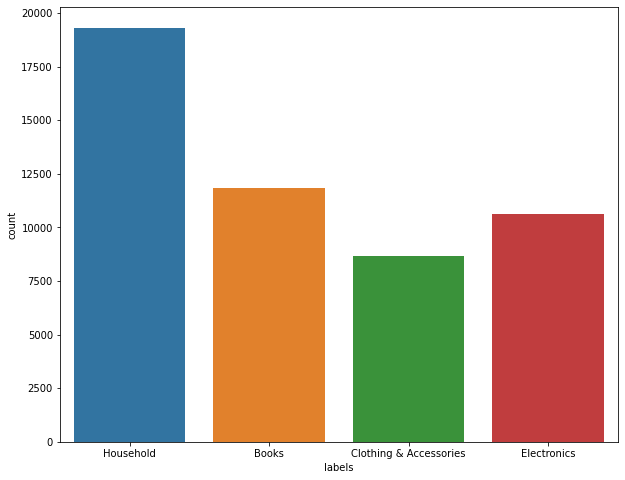

In [ ]:
#visualizing the label column
create_distribution(ecommerce_df)

In [ ]:
#dropping the row with a missing column
ecommerce_df.dropna(inplace=True)

In [ ]:
#examining the  dataframe for missing values
ecommerce_df.isna().sum()

labels    0
text      0
dtype: int64

In [ ]:
#downloading some necessary dependencies for the nltk library
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
# Preprocess the text with function processtext()
stop_words = stopwords.words('english')
punctuations = list(string.punctuation)
lemma = WordNetLemmatizer() # for Lemmatisation
# stop_words.extend()

def processtext(text):
    text=re.sub("[^a-zA-Z]"," ",text) # Filter to allow only alphabets in text
    text=text.lower() # Convert the text to lowercase to maintain consistency
    tokens=word_tokenize(text) # Tokenize the text
    # Remove stopwords and punctuations
    tokens=[token for token in tokens if token not in stop_words and token not in punctuations] 
    tokens=[lemma.lemmatize(token) for token in tokens] # Lemmatisation of tokens
    text = ' '.join([word for word in tokens if len(word) > 1]) #only let tokens more than one letter pass
    return text
ecommerce_df["text"] = ecommerce_df.text.apply(lambda x: processtext(x))

In [ ]:
#examining the rows of the cleaned dataset
ecommerce_df["text"]

0        paper plane design framed wall hanging motivat...
1        saf floral framed painting wood inch inch spec...
2        saf uv textured modern art print framed painti...
3        saf flower print framed painting synthetic inc...
4        incredible gift india wooden happy birthday un...
                               ...                        
50420    strontium microsd class gb memory card black m...
50421    crossbeats wave waterproof bluetooth wireless ...
50422    karbonn titanium wind white karbonn titanium w...
50423    samsung guru fm plus sm black colour black com...
50424                            micromax canvas win white
Name: text, Length: 50424, dtype: object

In [ ]:
#encoding the label columns
le = LabelEncoder()
ecommerce_df["labels"] = le.fit_transform(ecommerce_df["labels"])

In [ ]:
#examining the label column
ecommerce_df["labels"].unique()

array([3, 0, 1, 2])

In [ ]:
#splitting the dataset into train test split
X = ecommerce_df["text"]
y = ecommerce_df["labels"]

X_train, X_others, y_train, y_others = train_test_split(X,y, test_size = 0.2, random_state = 42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_others, y_others, test_size = 0.5, random_state = 42, stratify=y_others)

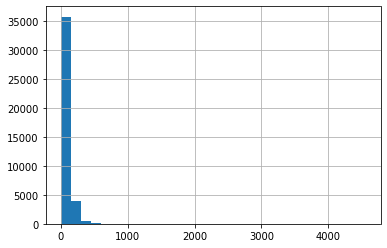

In [ ]:
#checking the distribution of texts
seq_len = [len(i.split()) for i in X_train]
pd.Series(seq_len).hist(bins=30)

# Modelling

In [ ]:
#installing transformers library to the work enviroment
!pip install transformers -q

     |████████████████████████████████| 4.9 MB 5.3 MB/s 
     |████████████████████████████████| 6.6 MB 50.3 MB/s 
     |████████████████████████████████| 120 kB 63.4 MB/s 


In [ ]:
#importing transformers and other necessary libraries for modelling
import transformers
from transformers import AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
#using the bert base uncased model
bert = AutoModel.from_pretrained('bert-base-uncased')

#load the bert tokenzer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
#setting the max sequence len to 512
max_seq_len = 512

In [ ]:

tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(),
    max_length = max_seq_len, 
    pad_to_max_length =True,
    truncation =True,
    return_tensors = 'pt',
    return_token_type_ids = False
)

tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(),
    max_length = max_seq_len, 
    pad_to_max_length =True,
    truncation =True,
    return_tensors = 'pt',
    return_token_type_ids = False
)

tokens_test = tokenizer.batch_encode_plus(
    X_test.tolist(),
    max_length = max_seq_len, 
    pad_to_max_length =True,
    truncation =True,
    return_tensors = 'pt',
    return_token_type_ids = False
)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2308: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [ ]:
#for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.tolist())

#for val set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(y_val.tolist())

#for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.tolist())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recomm

In [ ]:
#define a batchsize
batch_size = 64

#combine tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

#sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

#dataloader for trainset
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size = batch_size)

In [ ]:

#combine tensors for val
val_data = TensorDataset(val_seq, val_mask, val_y)

#sampler for sampling the data during training
val_sampler = RandomSampler(val_data)

#dataloader for valset
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size = batch_size)

In [ ]:
#combine tensors for test
test_data = TensorDataset(test_seq, test_mask, test_y)

#sampler for sampling the data during training
test_sampler = RandomSampler(test_data)

#dataloader for testset
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size = batch_size)

In [ ]:
for param in bert.parameters():
  param.requires_grad = False

In [ ]:
#loss function
cross_entropy = nn.NLLLoss()
#optimize from hugging face transformers
from transformers import AdamW
#define the optmizer
optimizer = AdamW(model.parameters(), lr=1e-3)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
#pass the pretrained bert into our architecture
model = BERT_Arch(bert)

model = model.to(device)

In [ ]:
class BERT_Arch(nn.Module):
  def __init__(self, bert):
    super(BERT_Arch, self).__init__()
    self.bert = bert
    #dropout layer
    self.dropout = nn.Dropout(0.1)
    #relu activation function
    self.relu = nn.ReLU()
    #dense layers
    self.fc1 = nn.Linear(768, 512)
    self.fc2 = nn.Linear(512, 4)
    #activation function
    self.softmax = nn.LogSoftmax(dim=1)
    #define the forward pass

  def forward(self, sent_id, mask):
    #pass the inputs to the model
    result = self.bert(sent_id, attention_mask = mask)
    last_hidden_state = result[0][:,-1,:]
    output = last_hidden_state.reshape(-1, last_hidden_state.shape[-1])
    output = self.fc1(output)
    output = self.relu(output)
    output = self.dropout(output)
    #output layer
    output = self.fc2(output)
    #apply softmax activation
    output = self.softmax(output)

    return output


# New Section

In [ ]:
# function to train the model
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  # empty list to save model predictions
  total_preds=[]
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    # push the batch to gpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    # clear previously calculated gradients 
    model.zero_grad()        
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
    # add on to the total loss
    total_loss += loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
#function for evaluating the model
def evaluate():
  print("\nEvaluating.....")
  #deactivate dropout layers
  model.eval()
  total_loss, total_accuracy = 0,0
  #empty list to save the model predictions
  total_preds = []
  #iterate over batches
  for step, batch in enumerate(val_dataloader):
    #progress update every 50 batches
    if step % 50 ==0 and not step ==0:
      #report progress
      print(' Batch {:>5,} of {:>5,}. '.format(step, len(val_dataloader)))
    #push the batch to the gpu
    batch = [t.to(device) for t in batch]
    sent_id, mask, labels = batch
    #deactivate autograd
    with torch.no_grad():
      #model predictions
      preds = model(sent_id, mask)
      #compute the validation loss between actual and predicted values
      loss = cross_entropy(preds, labels)
      #aoc value goes in here
      total_loss += loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  #compute the validation loss of the epoch
  avg_loss = total_loss /  len(val_dataloader)

  #reshape the predictions in form of (number of samples, no. of classes)
  total_preds = np.concatenate(total_preds, axis=0)
  return avg_loss, total_preds

In [ ]:
epochs = 5
#set initial loss to infinite
best_valid_loss = float('inf')
#empty list to store training and validation loss of each epoch
train_losses = []
valid_losses = []

#for eaxh epoch
for epoch in range(epochs):
  print('\n Epoch{:} / {:}'.format(epoch+1, epochs))
  #train model
  train_loss, _ = train()
  #evaluate model
  valid_loss, _ = evaluate()
  #save the best model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved_model.pt')

  #append training and validation loss
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print(f'\nTraining loss: {train_loss:.3f}')
  print(f'\nVaidation loss: {valid_loss:.3f}')


 Epoch1 / 5
  Batch    50  of    631.
  Batch   100  of    631.
  Batch   150  of    631.
  Batch   200  of    631.
  Batch   250  of    631.
  Batch   300  of    631.
  Batch   350  of    631.
  Batch   400  of    631.
  Batch   450  of    631.
  Batch   500  of    631.
  Batch   550  of    631.
  Batch   600  of    631.

Evaluating.....
 Batch    50 of    79. 

Training loss: 0.332

Vaidation loss: 0.289

 Epoch2 / 5
  Batch    50  of    631.
  Batch   100  of    631.
  Batch   150  of    631.
  Batch   200  of    631.
  Batch   250  of    631.
  Batch   300  of    631.
  Batch   350  of    631.
  Batch   400  of    631.
  Batch   450  of    631.
  Batch   500  of    631.
  Batch   550  of    631.
  Batch   600  of    631.

Evaluating.....
 Batch    50 of    79. 

Training loss: 0.269

Vaidation loss: 0.252

 Epoch3 / 5
  Batch    50  of    631.
  Batch   100  of    631.
  Batch   150  of    631.
  Batch   200  of    631.
  Batch   250  of    631.
  Batch   300  of    631.
  Batch  

In [ ]:
#load weights of best model
path =  'saved_model.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [42]:
     #testing the model in batches
total_loss = 0
total_roc = 0
total_accuracy = 0
test_preds = []
test_label = []
for step, batch in enumerate(test_dataloader):
  #progress update every 50 batches
  if step % 50 ==0 and not step ==0:
    #report progress
    print(' Batch {:>5,} of {:>5,}. '.format(step, len(test_dataloader)))
  #push the batch to the gpu
  batch = [t.to(device) for t in batch]

  sent_id, mask, labels = batch
  #deactivate autograd
  with torch.no_grad():
    #model predictions
    preds = model(sent_id, mask)
    total_loss += cross_entropy(preds, labels).item()
    preds = torch.argmax(preds, dim=1)
    label = labels.to('cpu').numpy()
    test_label.extend(label)
    preds = preds.detach().to('cpu').numpy()
    test_preds.extend(preds)
    #total_roc += roc_auc(preds, label)
    total_accuracy += accuracy_score(preds, label)

#creating a dataframe of the test label and test prediction 
predicted = pd.DataFrame(list(zip(test_label, test_preds)),
               columns =['Label', 'Predictions'])

mean_loss = total_loss / len(test_dataloader)
# total_roc = roc_auc(test_preds, test_label, multi_class='ovr', axis=0)
mean_accuracy = total_accuracy / len(test_dataloader)

print(f'model loss: {mean_loss} \nmodel accuracy: {mean_accuracy}')

 Batch    50 of    79. 
model loss: 0.22775402415213705 
model roc: 0 
model accuracy: 0.9304224063042938


In [43]:
#print the classification report
print(classification_report(test_label, test_preds))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1182
           1       0.95      0.93      0.94       867
           2       0.93      0.89      0.91      1062
           3       0.91      0.95      0.93      1932

    accuracy                           0.93      5043
   macro avg       0.94      0.93      0.93      5043
weighted avg       0.93      0.93      0.93      5043

